In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from uti.LR_find_Schduler_05c import *

In [3]:
x_train,y_train,x_valid,y_valid = get_data()

/home/jupyter/.fastai/data/mnist.pkl.gz


In [4]:
m = x_train.mean()
std = x_train.std()
m,std

(tensor(0.1304), tensor(0.3073))

In [5]:
#export
def normalize_data(train,valid):
    #pass train / valid x to normalize data
    
    m,std = train.mean(), train.std()
    return (train - m) / std, (valid - m) /std

In [6]:
x_train, x_valid = normalize_data(x_train,x_valid)

In [7]:
x_train.mean(),x_train.std()

(tensor(0.0001), tensor(1.))

In [8]:
train_ds, valid_ds = get_dataset(x_train,y_train,x_valid,y_valid)
data = Databunch(*get_dl(train_ds,valid_ds,bs=64),c=len(y_train.unique()))

In [9]:
#export
class Lambda(nn.Module):
    def __init__(self,func):
        super().__init__()
        self.func = func
        
    def forward(self,xb):
        return self.func(xb)
    
def flatten(x):
    return x.view(x.shape[0],-1)

In [10]:
def get_cnn(out_shape):
    model = nn.Sequential(
        Lambda(lambda x: x.view(-1,1,28,28)),
        nn.Conv2d(1,8,5,stride=2,padding=2),nn.ReLU(), #14
        nn.Conv2d(8,16,3,stride=2,padding=1),nn.ReLU(), #7
        nn.Conv2d(16,32,3,stride=2,padding=1),nn.ReLU(), #4
        nn.Conv2d(32,32,3,stride=2,padding=1),nn.ReLU(), #2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32,out_shape),
    )
    return model

In [11]:
model = get_cnn(10)

In [12]:
model

Sequential(
  (0): Lambda()
  (1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (2): ReLU()
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (8): ReLU()
  (9): AdaptiveAvgPool2d(output_size=1)
  (10): Lambda()
  (11): Linear(in_features=32, out_features=10, bias=True)
)

In [13]:
cbs = [Recorder(),Accuracy()]

In [14]:
opt = optim.SGD(model.parameters(),lr=0.5)

In [15]:
learn = NewLearner(model,opt,F.cross_entropy,data,cbs=cbs)

In [16]:
%time learn.fit(2)

Train: 0.4260792136192322, 0.8597999811172485
Valid: 0.09686563163995743, 0.9711999893188477
 
Train: 0.09249963611364365, 0.9713600277900696
Valid: 0.2742413282394409, 0.923799991607666
 
CPU times: user 32.2 s, sys: 11.6 s, total: 43.8 s
Wall time: 22.8 s


# Refactor

In [11]:
def conv2d(ni,nf,ks=3,stride=2):
    return nn.Sequential(
        nn.Conv2d(ni,nf,ks,padding=ks//2,stride=stride),nn.ReLU(),
    )

In [12]:
#export
class BatchTransformXCallback(Callback):
    _order = 2
    def __init__(self,tfm):
        self.tfm = tfm
    
    def begin_batch(self):
        self.learn.xb = self.tfm(self.learn.xb)
        
def view_tfm(*args):
    def _inner(x): return x.view((-1,)+args)
    return _inner

In [13]:
f = view_tfm(1,28,28)
batch_resize = BatchTransformXCallback(f)

In [14]:
cbs = [Recorder(),Accuracy(),batch_resize]

In [15]:
nfs = [8,16,32,32]

In [16]:
def get_cnn_layers(data,nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i],nfs[i+1],5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1),Lambda(flatten),nn.Linear(nfs[-1],data.c)]

def get_cnn_model(data,nfs):
    return nn.Sequential(*get_cnn_layers(data,nfs))

In [17]:
#export
def get_learner(model,data,lr=0.6,cbs=None,opt_func=None,loss_func=F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(),lr=lr)
    return NewLearner(model,opt,loss_func,data,cbs=cbs)

In [18]:
model = get_cnn_model(data,nfs)
learn = get_learner(model,data,cbs=cbs)

In [19]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [25]:
learn.fit(3)

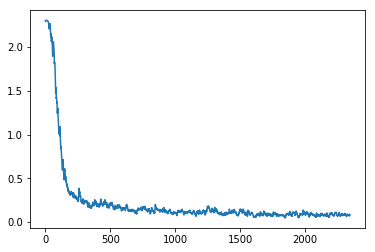

In [55]:
cbs[0].plot_loss()

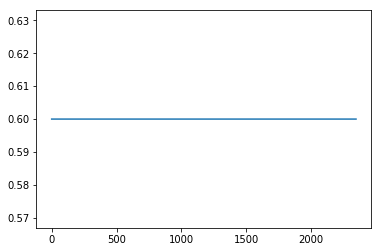

In [56]:
cbs[0].plot_lr()

In [19]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]
act_means

[[], [], [], [], [], [], []]

In [20]:
def append_act(i,mod,input,output):
    if mod.training:
        act_means[i].append(output.data.mean())
        act_means[i].append(output.data.std())

In [45]:
cbs = [batch_resize]
model = get_cnn_model(data,nfs)
learn = get_learner(model,data,cbs=cbs,lr=0.9)

In [21]:
for i,m in enumerate(model):
    m.register_forward_hook(partial(append_act,i))

In [22]:
learn.fit(1)

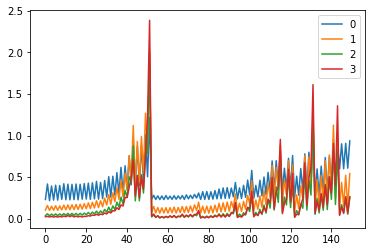

In [27]:
for o in act_means[:4]:
    plt.plot(o[:150])
plt.legend(range(4))

In [31]:
test_child = list(model.children())
model[0][0]

Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))

In [35]:
test_child[0][0]

Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))

In [46]:
for l in model:
    if isinstance(l,nn.Sequential):
        print(l)

Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (1): ReLU()
)
Sequential(
  (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)
Sequential(
  (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)
Sequential(
  (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)


In [47]:
xb,yb = next(iter(learn.data.train_dl))
xb.shape

torch.Size([64, 784])

In [48]:
xb = xb.view(-1,1,28,28)
xb.shape

torch.Size([64, 1, 28, 28])

In [49]:
l = model[0]

In [50]:
l[0].weight.mean(),l[0].weight.std()

(tensor(-0.0037, grad_fn=<MeanBackward1>),
 tensor(0.1117, grad_fn=<StdBackward0>))

In [51]:
xb.mean(),xb.std()

(tensor(0.0065), tensor(1.0060))

In [52]:
xb_1 = l(xb)
xb_1.shape

torch.Size([64, 8, 14, 14])

In [53]:
xb_1.mean(),xb_1.std()

(tensor(0.1489, grad_fn=<MeanBackward1>),
 tensor(0.2973, grad_fn=<StdBackward0>))

# Kaiming init l

In [54]:
nn.init.kaiming_normal_(l[0].weight)
l[0].weight.mean(),l[0].weight.std()

(tensor(-0.0180, grad_fn=<MeanBackward1>),
 tensor(0.2760, grad_fn=<StdBackward0>))

In [60]:
l[0].bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0.])

In [61]:
xb_1_new = l(xb)
xb_1_new.mean(),xb_1_new.std()

(tensor(0.4342, grad_fn=<MeanBackward1>),
 tensor(0.7558, grad_fn=<StdBackward0>))

In [63]:
(xb_1_new.data - 0.5).mean(),(xb_1_new.data - 0.5).std()

(tensor(-0.0658), tensor(0.7558))

In [65]:
cbs = [batch_resize]
model = get_cnn_model(data,nfs)
learn = get_learner(model,data,cbs=cbs,lr=0.9)

In [66]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]
act_means

[[], [], [], [], [], [], []]

In [68]:
for l in model:
    if isinstance(l,nn.Sequential):
        nn.init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [69]:
for i,m in enumerate(model):
    m.register_forward_hook(partial(append_act,i))

In [70]:
learn.fit(1)

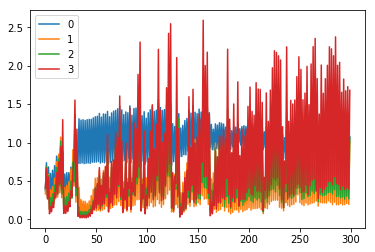

In [74]:
for o in act_means[:4]:
    plt.plot(o[:300])
plt.legend(range(4))

# The poor man's version of relu() - sub
This is during the fastai course, we found that for initialization, we would like to have mean 0 and std 1
However, for kaiming init, after relu(), it is actually giving mean 0.5 and std 1. 
This is easy to think about, when you do initialization, you didn't take into account of the relu() layer, where half of the data is chopped to 0, which in turn, will shift the mean from 0 to 0.5 roughly. 
By testing the relu() layer subtract a small number, say 0.4, we actually have better data distribution of mean 0 and std 1

In [125]:
def poor_relu_sub(x,sub=0.4):
    return x.data - sub

In [126]:
def conv2d_(ni,nf,ks=3,stride=2):
    return nn.Sequential(
        nn.Conv2d(ni,nf,ks,padding=ks//2,stride=stride),nn.ReLU(),
        Lambda(poor_relu_sub)
    )

In [127]:
xb,yb = next(iter(learn.data.train_dl))
xb.shape,yb.shape

(torch.Size([64, 784]), torch.Size([64]))

In [128]:
test_layer_1 = conv2d_(1,3)
test_regular = conv2d(1,3)
xb = xb.view(-1,1,28,28)

In [129]:
nn.init.kaiming_normal_(test_regular[0].weight)
nn.init.kaiming_normal_(test_layer_1[0].weight)
test_regular[0].bias.data.zero_()
test_layer_1[0].bias.data.zero_()

tensor([0., 0., 0.])

In [130]:
res_regular = test_regular(xb)
res_regular.shape

torch.Size([64, 3, 14, 14])

In [131]:
res_poor_relu = test_layer_1(xb)
res_poor_relu.shape

torch.Size([64, 3, 14, 14])

In [132]:
res_regular.mean(),res_regular.std()

(tensor(0.2928, grad_fn=<MeanBackward1>),
 tensor(0.5804, grad_fn=<StdBackward0>))

In [133]:
res_poor_relu.mean(),res_poor_relu.std()

(tensor(0.1077), tensor(1.1823))

# Fin
Finished batchnorm.
Build:
1. callbacks
2. learner
3. scheduler
4. LR_find
5. general relu
6. hooks
7. understand pytorch nn.Sequential

From now, I will switch to fastai library. The goal for this play ground is to understand fastai better :)

Left: implement datablock API